<a href="https://colab.research.google.com/github/Brent-Morrison/Misc_scripts/blob/master/theil_sen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Abalone and Outliers  

That title deserves an explanation. 

This note will look at the Theil Sen estimator for **robust regression**.  I'm going to use the UCI Machine Learning abalone dataset to compare this technique with Ordinary Least Squares.

Robust techniques are designed to mitigate the impact of outliers in regression models.  My introduction to Theil Sen was through this [paper](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2802478) which looks at stock valuations.

The Theil Sen was first applied on univariate data.  It estimates the regression slope by taking the median of individual slopes, those being fitted to each pair of data points.  If there are n data points, there will be n*(n-1)/2 individual slopes to estimate.  As stated, the final slope is the median of these. 

That concept is easy enough to wrap your head around.  [This](https://blogs.sas.com/content/iml/2019/05/28/theil-sen-robust-regression.html) blog on the SAS website has some nice visuals to help.

Theil Sen has been extended to apply to multivariate data by [this paper](http://home.olemiss.edu/~xdang/papers/MTSE.pdf).  Scikit Learn has an [implementation](https://scikit-learn.org/stable/modules/linear_model.html#theil-sen-estimator-generalized-median-based-estimator) of this, using the spatial median which is a generalization of the median to multiple dimensions.  
  
The concept of a spatial median is a lttle tougher grasp.  Running some data through both the Theil Sen and OLS estimators may help with our intuition here.

Let's get to it.  
<br>
<br>
## Libraries and data

Data is from the UCI Machine Learning repository and contains the age of abalone and their physical measurements.  Hence the title.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
cols = ['sex','length','diam','height','whole','shucked','viscera','shell','rings']

In [3]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data', names=cols)

In [4]:
df

,sex,length,diam,height,whole,shucked,viscera,shell,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


In [5]:
df.dtypes

sex         object
length     float64
diam       float64
height     float64
whole      float64
shucked    float64
viscera    float64
shell      float64
rings        int64
dtype: object

Drop the categorical `sex` attribute.  We are investigating a regression problem here.  Yes, we could have encoded as dummy variable or fit a mixed effects model.  I'm going to keep it simple.

In [6]:
df.drop(columns='sex', inplace=True)
df

,length,diam,height,whole,shucked,viscera,shell,rings
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...
4172,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


<br>
<br>

## Independent and dependent variables.  
The `rings` variable is what we are trying to predict.  This is a proxy for the age of the abalone.  
  
Don't get too caught up on the data and regression problem at this stage. I just need a real world dataset to investigate the differences between robust and OLS methodologies.  

In [7]:
x = df.iloc[:, 0:7]
y = df.iloc[:, 7:8]

<br>
<br>

## Let's visualise our data

Histograms of each feature.

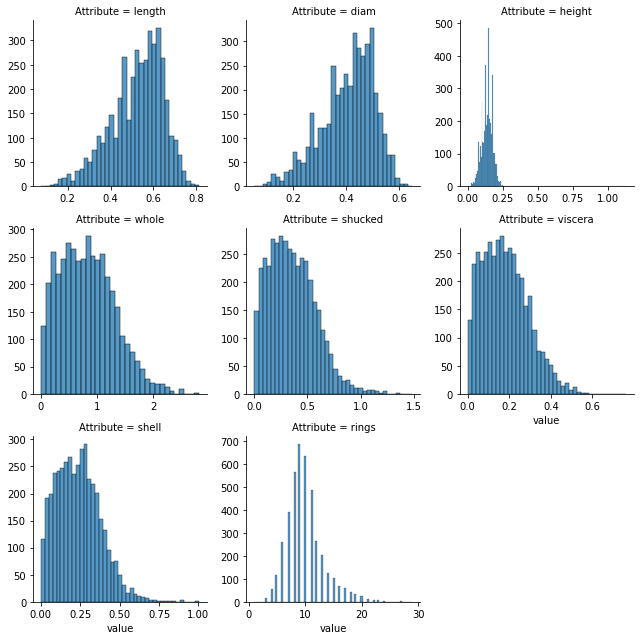

In [8]:
sns.FacetGrid(
    data=df.melt(var_name='Attribute', value_name='value'),
    col='Attribute',
    col_wrap=3,
    sharex=False,
    sharey=False) \
.map(sns.histplot, 'value')

And scatter plots of each feature and the dependent variable.

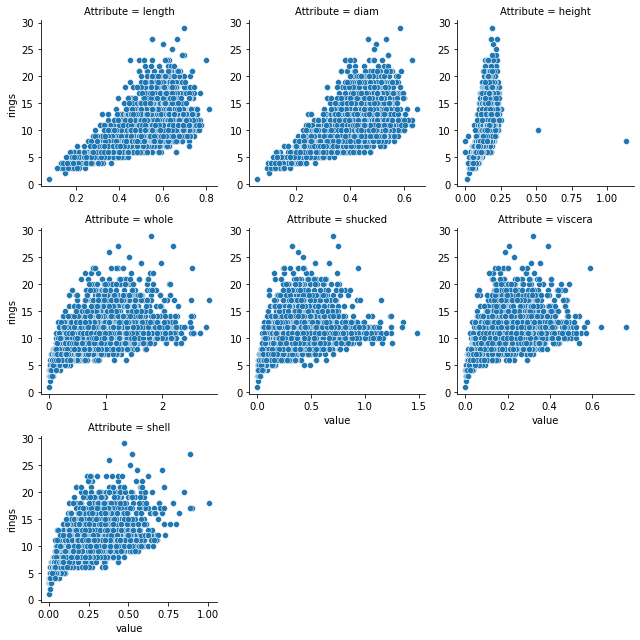

In [9]:
sns.FacetGrid(
    data=df.melt(var_name='Attribute', value_name='value', value_vars=['length', 'diam', 'height', 'whole', 'shucked', 'viscera', 'shell'], ignore_index=False).join(y),
    col='Attribute',
    col_wrap=3,
    sharex=False,
    sharey=False) \
.map(sns.scatterplot, 'value', 'rings')

With the exception of the height attribute, there are no obvious outliers.
<br>
<br>

## Ordinary Least Squares estimation

I'm using `statsmodels` for the OLS estimation.  It produces a nice summary result.

In [10]:
x = sm.add_constant(x)
ols = sm.OLS(y,x).fit()
sm_pred = ols.predict(x)

print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                  rings   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.527
Method:                 Least Squares   F-statistic:                     665.2
Date:                Mon, 23 Aug 2021   Prob (F-statistic):               0.00
Time:                        20:13:27   Log-Likelihood:                -9250.0
No. Observations:                4177   AIC:                         1.852e+04
Df Residuals:                    4169   BIC:                         1.857e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9852      0.269     11.092      0.0

<br>
<br>

## Theil Sen estimation
Now to Theil Sen, using Scikit Learn.

In [11]:
# Create regression object
ts = linear_model.TheilSenRegressor()

# Fit the model
ts.fit(x, np.ravel(y))

# Print the intercept, co-efficients & R-squared
for i in zip(x.columns.tolist(), ts.coef_):
  print(i[0].ljust(10),' :', '{:>9.2f}'.format(i[1]))

print('R-squared'.ljust(10),' :', '{:>9.2f}'.format(ts.score(x, np.ravel(y))))

const       :      2.08
length      :     -6.41
diam        :     11.16
height      :     23.40
whole       :     13.17
shucked     :    -24.88
viscera     :    -13.46
shell       :      7.02
R-squared   :      0.51


## Model comparison

Lets compare the regression co-efficients and model fit.

In [12]:
ts_coef = zip(x.columns.tolist(), ts.coef_)
ts_coef = pd.DataFrame(ts_coef, columns = ['Variable', 'TS coef'])

ols_coef = ols.params.to_frame(name='OLS coef').rename_axis('Variable')
ols_coef.reset_index(inplace=True)

coef = ts_coef.merge(ols_coef, on='Variable')
coef['Diff in coef'] = coef['TS coef'] - coef['OLS coef']
coef.round(2)

,Variable,TS coef,OLS coef,Diff in coef
0,const,2.08,2.99,-0.91
1,length,-6.41,-1.57,-4.84
2,diam,11.16,13.36,-2.20
3,height,23.40,11.83,11.57
4,whole,13.17,9.25,3.92
5,shucked,-24.88,-20.21,-4.67
6,viscera,-13.46,-9.83,-3.63
7,shell,7.02,8.58,-1.56


The fit models are similar with the sign of coefficients in alignment.  
  
We can see how the OLS estimate of the height coefficient is dragged down by the outliers.  The Thiel Sen approach, by virtue of the estimation methodology explained above, places less weight on these outliers.  This is to be expected with a robust technique.  

The r-squared values are similar at around 0.5.
<br>
<br>
<br>
## Inserting outliers
Below, we amend a subset of 200 records in order to transform these into outliers.  100 records are multiplied by 5, and 100 records divided by 5.  These artifical outliers represents around 5% of our data (there are 4,177 records in total).

In [13]:
df1 = df

df1.iloc[0:100, 0:7] = df1.iloc[0:100, 0:7].multiply(5)

In [14]:
df1.iloc[4076:4177, 0:7] = df1.iloc[4076:4177, 0:7].div(5)

In [15]:
df1.iloc[:, 0:7]

,length,diam,height,whole,shucked,viscera,shell
0,2.275,1.825,0.475,2.5700,1.1225,0.5050,0.7500
1,1.750,1.325,0.450,1.1275,0.4975,0.2425,0.3500
2,2.650,2.100,0.675,3.3850,1.2825,0.7075,1.0500
3,2.200,1.825,0.625,2.5800,1.0775,0.5700,0.7750
4,1.650,1.275,0.400,1.0250,0.4475,0.1975,0.2750
...,...,...,...,...,...,...,...
4172,0.113,0.090,0.033,0.1774,0.0740,0.0478,0.0498
4173,0.118,0.088,0.027,0.1932,0.0878,0.0429,0.0521
4174,0.120,0.095,0.041,0.2352,0.1051,0.0575,0.0616
4175,0.125,0.097,0.030,0.2189,0.1062,0.0522,0.0592


In [16]:
x1 = df1.iloc[:, 0:7]
y1 = df1.iloc[:, 7:8]

## Visualise data with artificial outliers

The plots below replicate those shown above, except using the amended data containing artificial outliers. 

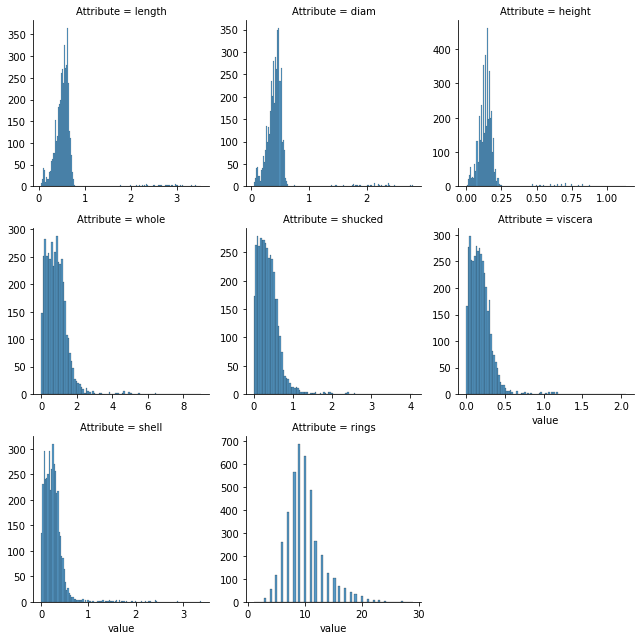

In [17]:
sns.FacetGrid(
    data=df1.melt(var_name='Attribute', value_name='value'),
    col='Attribute',
    col_wrap=3,
    sharex=False,
    sharey=False) \
.map(sns.histplot, 'value')

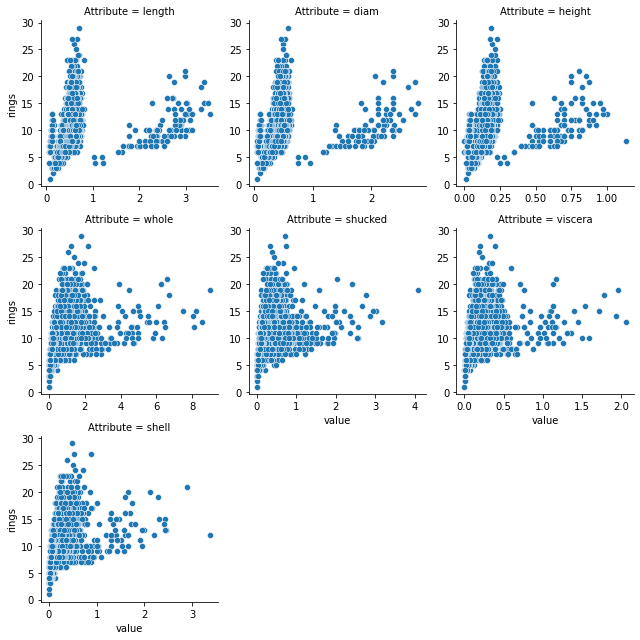

In [18]:
sns.FacetGrid(
    data=df1.melt(var_name='Attribute', value_name='value', value_vars=['length', 'diam', 'height', 'whole', 'shucked', 'viscera', 'shell'], ignore_index=False).join(y1),
    col='Attribute',
    col_wrap=3,
    sharex=False,
    sharey=False) \
.map(sns.scatterplot, 'value', 'rings')

Naturally the data becomes a lot more skewed.  The scatterplot highlights the artificial outliers very clearly.
<br>
<br>

## OLS estimation (with artificial outliers)

In [19]:
x1 = sm.add_constant(x1)
ols_o = sm.OLS(y1,x1).fit()
sm_pred= ols_o.predict(x1)

print(ols_o.summary())

                            OLS Regression Results                            
Dep. Variable:                  rings   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.333
Method:                 Least Squares   F-statistic:                     298.8
Date:                Mon, 23 Aug 2021   Prob (F-statistic):               0.00
Time:                        20:13:35   Log-Likelihood:                -9967.2
No. Observations:                4177   AIC:                         1.995e+04
Df Residuals:                    4169   BIC:                         2.000e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.5868      0.084    114.707      0.0

## Thiel Sen estimation (with artificial outliers)

In [20]:
# Create regression object
ts_o = linear_model.TheilSenRegressor()

# Fit the model
ts_o.fit(x1, np.ravel(y1))

# Print the intercept, co-efficients & R-squared
for i in zip(x1.columns.tolist(), ts_o.coef_):
  print(i[0].ljust(10),' :', '{:>9.2f}'.format(i[1]))

print('R-squared'.ljust(10),' :', '{:>9.2f}'.format(ts_o.score(x1, np.ravel(y1))))

const       :      2.76
length      :     -9.97
diam        :     11.31
height      :     19.35
whole       :     12.91
shucked     :    -23.39
viscera     :    -12.50
shell       :      9.30
R-squared   :     -0.62


## Comparison of models

In [21]:
ts_coef = zip(x1.columns.tolist(), ts_o.coef_)
ts_coef = pd.DataFrame(ts_coef, columns = ['Variable', 'TS coef (outliers)'])

ols_coef = ols_o.params.to_frame(name='OLS coef (outliers)').rename_axis('Variable')
ols_coef.reset_index(inplace=True)

coef_o = ts_coef.merge(ols_coef, on='Variable')

coef = coef.merge(coef_o, on='Variable')

coef['Diff in coef (outliers)'] = coef['TS coef (outliers)'] - coef['OLS coef (outliers)']
coef['TS coef (diff)'] = coef['TS coef'] - coef['TS coef (outliers)']
coef['OLS coef (diff)'] = coef['OLS coef'] - coef['OLS coef (outliers)']
coef.round(2)

,Variable,TS coef,OLS coef,Diff in coef,TS coef (outliers),OLS coef (outliers),Diff in coef (outliers),TS coef (diff),OLS coef (diff)
0,const,2.08,2.99,-0.91,2.76,9.59,-6.83,-0.68,-6.60
1,length,-6.41,-1.57,-4.84,-9.97,-12.16,2.19,3.56,10.59
2,diam,11.16,13.36,-2.20,11.31,6.81,4.50,-0.15,6.55
3,height,23.40,11.83,11.57,19.35,6.87,12.48,4.05,4.96
4,whole,13.17,9.25,3.92,12.91,5.60,7.31,0.26,3.64
5,shucked,-24.88,-20.21,-4.67,-23.39,-10.14,-13.26,-1.49,-10.08
6,viscera,-13.46,-9.83,-3.63,-12.50,1.40,-13.89,-0.96,-11.23
7,shell,7.02,8.58,-1.56,9.30,7.08,2.22,-2.28,1.50


## Observations

### OLS model
The r-squared is now much lower for the OLS model. From 0.5 on the original data to 0.3 on the data with the artificial outliers inserted.  This makes sense in the context of the outliers increasing the variance of the data.

The difference in coefficients is substantial, for example viscera has increased from -9.8 to 1.4, and length from -1.6 to -12.1.  Interestingly, shell has changed by a much smaller relative amount, 8.6 to 7.1.  

Why is this?  Why has the sign of the coefficient on viscera changed?  

It appears there is excessive multicollinearity in the original dataset, and this has given rise to spurious or unstable coefficients.  A small(ish) change to the data has given rise to large changes in coefficients.  Going back to the original data reveals an average pairwise correlation of around 0.9.
<br>
<br>
### Theil Sen model

The Thiel Sen model coefficients are much more stable and have not changed sign.  The largest change, the length coefficient, has almost doubled from -5.7 to -10.9.  This variable has the largest change in coefficient in both the Theil Sen and OLS models.

The r-squared for the model with outliers has decreased to -0.56 (yes, negative).  This is because the model in aggregate has worse predictions than simply predicting the baseline, the average of the y values.  This result makes sense in the context of the solution that Theil Sen implements; if outliers are not taken into account when coefficients are derived (remember it is the median of all slopes across all data points), these will result in large prediction errors.  

Below the r-squared is calculated for data points including and excluding the artificial outliers.  The values for this are -0.27 and 0.51 respectively.

It should be noted that by virtue of the method of inserting outliers, the correlation structure of the data has been preserved.
<br>
<br>
## Conclusion

This has been a quick little piece of analysis.  What have we learned?

1. Multi-collinearity can lead to unstable regression coefficents  
2. The r-squared based on models fit using robust techniques may be spurious if data is bifurcated similar to that artificially induced above  
3. Theil Sen regression is another string in your bow.  



<br>
<br>

---

<br>
<br>

## Scratch workings

### R-squared information

In [22]:
# r-squared - OLS with outliers
ols_o.rsquared

0.3340788540256908

In [23]:
# r-squared - TS with outliers
ts_o.score(x1, np.ravel(y1))

-0.6166942787878218

In [24]:
# r-squared - TS on ALL data points
ts_o.score(x1, y1)

-0.6166942787878218

In [25]:
# r-squared - TS on data points that ARE outliers
ts_o.score(x1.iloc[np.r_[0:100,4076:4176]], y1.iloc[np.r_[0:100,4076:4176]])

-29.564854211258634

In [26]:
# r-squared - TS on data points that ARE NOT outliers
ts_o.score(x1.iloc[np.r_[101:4075]], y1.iloc[np.r_[101:4075]])

0.5081364119559657

### Average pairwise correlation of original data set

In [27]:
df_corr = df.iloc[:, 0:7].corr()
df_corr

,length,diam,height,whole,shucked,viscera,shell
length,1.000000,0.997471,0.962519,0.861553,0.827044,0.850503,0.868906
diam,0.997471,1.000000,0.964844,0.871345,0.835328,0.858122,0.879775
height,0.962519,0.964844,1.000000,0.869090,0.827839,0.857939,0.880715
whole,0.861553,0.871345,0.869090,1.000000,0.977039,0.973434,0.971785
shucked,0.827044,0.835328,0.827839,0.977039,1.000000,0.955973,0.915816
viscera,0.850503,0.858122,0.857939,0.973434,0.955973,1.000000,0.928095
shell,0.868906,0.879775,0.880715,0.971785,0.915816,0.928095,1.000000


In [28]:
np.nanmean(df_corr.values[np.triu_indices_from(df_corr.values,1)])

0.901673180385633

### Average pairwise correlation of outliers data set

In [29]:
df_corr_o = df1.iloc[:, 0:7].corr()
np.nanmean(df_corr_o.values[np.triu_indices_from(df_corr_o.values,1)])

0.901673180385633

### Attributes associated with regression model objects

In [30]:
dir(ts_o)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_subparams',
 '_decision_function',
 '_estimator_type',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_preprocess_data',
 '_set_intercept',
 'breakdown_',
 'coef_',
 'copy_X',
 'fit',
 'fit_intercept',
 'get_params',
 'intercept_',
 'max_iter',
 'max_subpopulation',
 'n_iter_',
 'n_jobs',
 'n_subpopulation_',
 'n_subsamples',
 'predict',
 'random_state',
 'score',
 'set_params',
 'tol',
 'verbose']

In [31]:
dir(ols_o)

['HC0_se',
 'HC1_se',
 'HC2_se',
 'HC3_se',
 '_HCCM',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_cache',
 '_data_attr',
 '_get_robustcov_results',
 '_is_nested',
 '_wexog_singular_values',
 'aic',
 'bic',
 'bse',
 'centered_tss',
 'compare_f_test',
 'compare_lm_test',
 'compare_lr_test',
 'condition_number',
 'conf_int',
 'conf_int_el',
 'cov_HC0',
 'cov_HC1',
 'cov_HC2',
 'cov_HC3',
 'cov_kwds',
 'cov_params',
 'cov_type',
 'df_model',
 'df_resid',
 'diagn',
 'eigenvals',
 'el_test',
 'ess',
 'f_pvalue',
 'f_test',
 'fittedvalues',
 'fvalue',
 'get_influence',
 'get_prediction',
 'get_robustcov_results',
 'initialize',
 'k_constant',
 'llf',
 'load',
 'model',
